# MNIST model with the built-in things from the changes

In [63]:
from typing import Tuple, List
from collections import deque

import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim import Optimizer

import numpy as np
from torch import Tensor

import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss

from layers import Layer, Dense
from model import Model
from train import Trainer
from utils import assert_dim

## Convolutional layer

In [64]:
class ConvLayer(Layer):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 filter_size: int,
                 activation: nn.Module = None,
                 dropout: float = 1.0,
                 flatten: bool = False) -> None:
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, filter_size, 
                              padding=filter_size // 2)
        self.activation = activation
        self.flatten = flatten
        if dropout < 1.0:
            self.dropout = nn.Dropout(1 - dropout)

    def forward(self, x: Tensor) -> Tensor:

        x = self.conv(x)
        if self.activation:
            x = self.activation(x)
        if self.flatten:
            x = x.contiguous().view(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3])
        if hasattr(self, "dropout"):
            x = self.dropout(x)            
            
        return x

## De-convolutional layer

In [65]:
class DeconvLayer(Layer):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 filter_size: int,
                 activation: nn.Module = None,
                 dropout: float = 1.0,
                 flatten: bool = False) -> None:
        super().__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, filter_size, 
                                       padding=filter_size // 2)
        self.activation = activation
        self.flatten = flatten
        if dropout < 1.0:
            self.dropout = nn.Dropout(1 - dropout)

    def forward(self, x: Tensor) -> Tensor:

        x = self.deconv(x)
        if self.activation:
            x = self.activation(x)
        if self.flatten:
            x = x.view(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3])
        if hasattr(self, "dropout"):
            x = self.dropout(x)            
            
        return x

## Auto-encoder model

In [66]:
class Autoencoder(Model):
    def __init__(self,
                 hidden_dim: int = 28):
        super(Autoencoder, self).__init__()
        self.conv1 = ConvLayer(1, 14, 5, activation=nn.Tanh())
        self.conv2 = ConvLayer(14, 7, 5, activation=nn.Tanh(), flatten=True)
        
        self.dense1 = Dense(7 * 28 * 28, hidden_dim, activation=nn.Tanh())
        self.dense2 = Dense(7 * 28 * 28, hidden_dim, activation=nn.Tanh())
        
        self.conv3 = ConvLayer(7, 14, 5, activation=nn.Tanh()) 
        self.conv4 = ConvLayer(14, 1, 5, activation=nn.Tanh())         

    def forward(self, x: Tensor) -> Tensor:
        assert_dim(x, 4)
            
        x = self.conv1(x)
        
        x = self.conv2(x)

        print(x.size())
        encoding = self.dense1(x)

        x = self.dense2(encoding)
        
        x = x.view(-1, 7, 28, 28)
        
        x = self.conv3(x)
        x = self.conv4(x)

        return x, encoding

## Prep the data

In [67]:
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

img_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1305,), (0.3081,))
])

In [68]:
train_dataset = MNIST(root='../mnist_data/',
                      train=True, 
                      download=True,
                      transform=img_transforms)

test_dataset = MNIST(root='../mnist_data/',
                     train=False, 
                     download=True,
                     transform=img_transforms)

mnist_train = ((train_dataset.data.type(torch.float32).unsqueeze(3).permute(0, 3, 1, 2) / 255.0) - 0.1305) / 0.3081
mnist_test = ((test_dataset.data.type(torch.float32).unsqueeze(3).permute(0, 3, 1, 2) / 255.0) - 0.1305) / 0.3081

X_train = mnist_train
X_test = mnist_test

X_train_auto = (X_train - X_train.min()) / (X_train.max() - X_train.min()) * 2 - 1
X_test_auto = (X_test - X_train.min()) / (X_train.max() - X_train.min()) * 2 - 1

In [69]:
model = Autoencoder(hidden_dim=28)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

trainer = Trainer(model, optimizer, criterion)

trainer.fit(X_train_auto, X_train_auto,
            X_test_auto, X_test_auto,
            epochs=1,
            batch_size=60)

In [70]:
reconstructed_images, image_representations = model(X_test_auto)

torch.Size([10000, 5488])


/home/lethanh/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lethanh/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


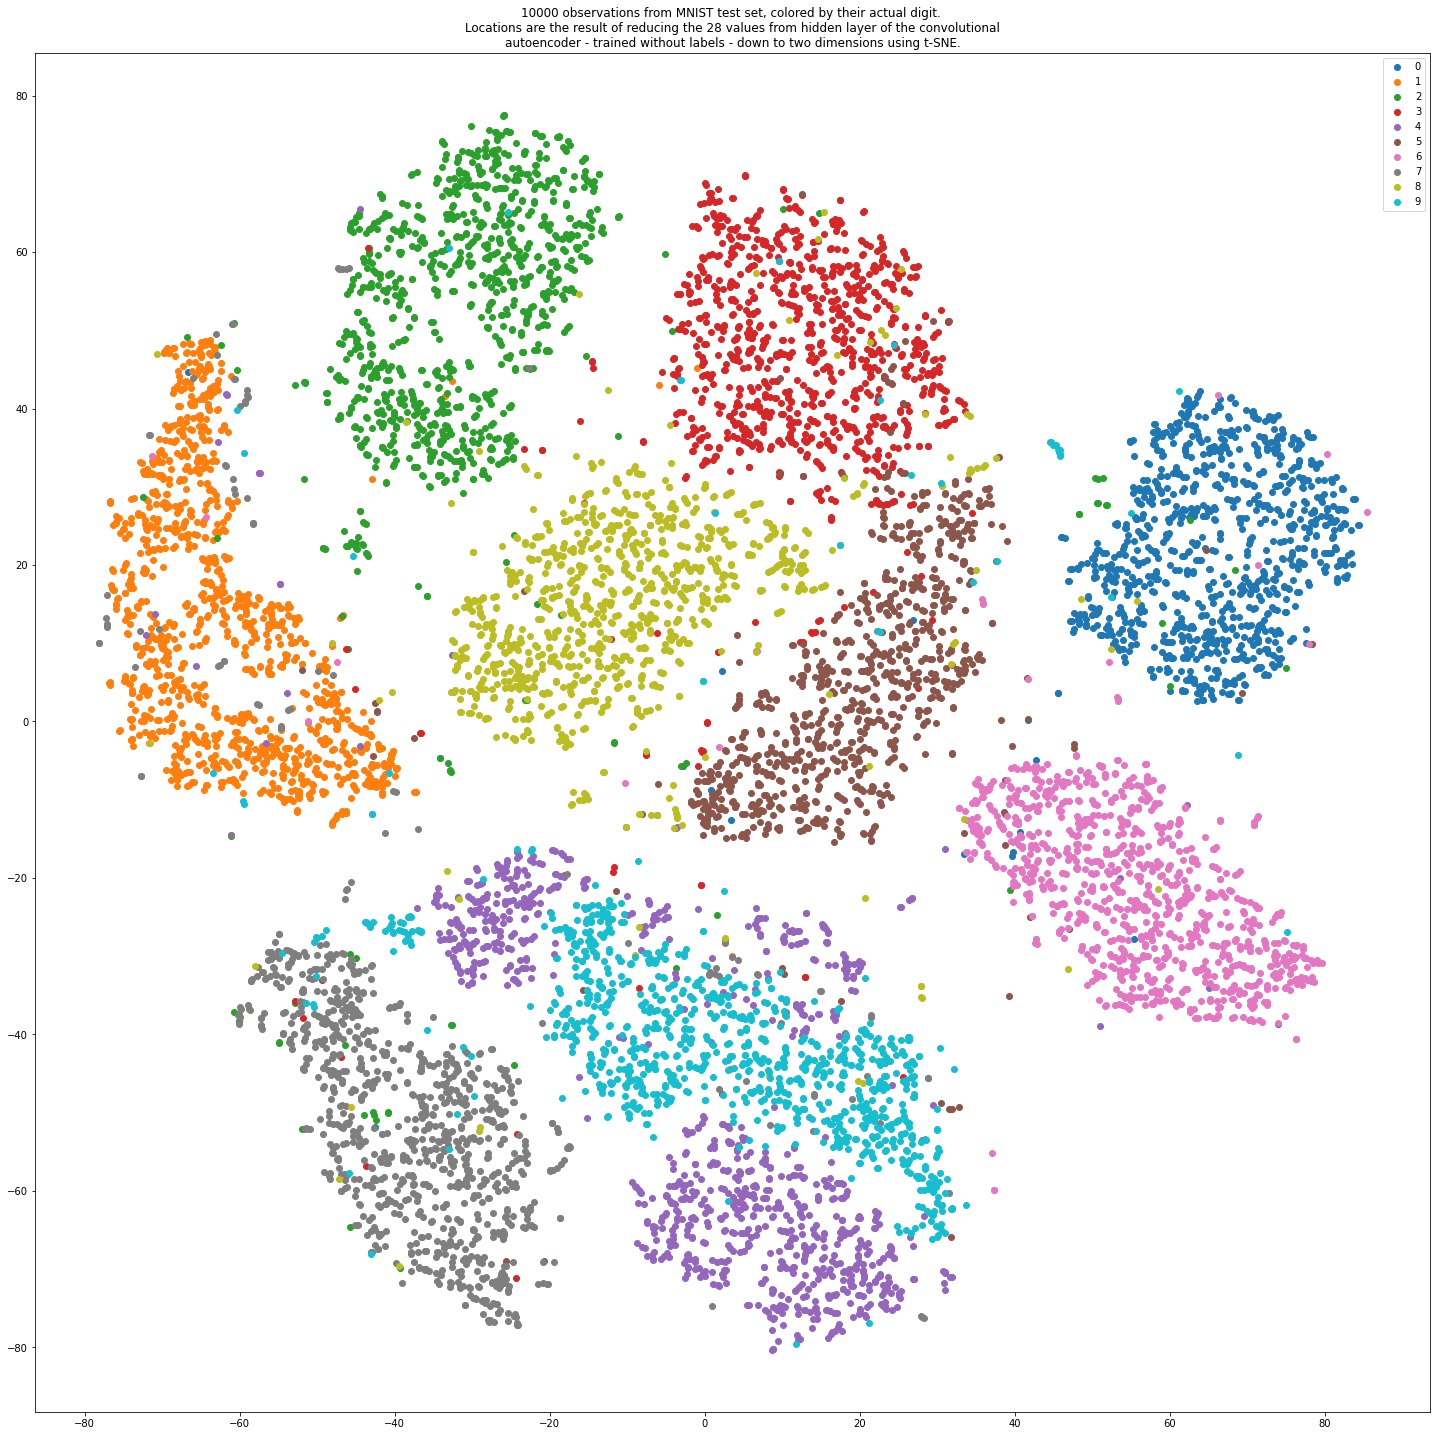

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne_result = TSNE(n_components=2, random_state=20190405).fit_transform(image_representations.detach().numpy())
tsne_df = pd.DataFrame({'tsne_dim_1': tsne_result[:,0],
              'tsne_dim_2': tsne_result[:,1],
              'category': test_dataset.targets})
groups = tsne_df.groupby('category')


# Plot
fig, ax = plt.subplots(figsize=(25,25))
ax.set_title('''10000 observations from MNIST test set, colored by their actual digit. 
Locations are the result of reducing the 28 values from hidden layer of the convolutional
autoencoder - trained without labels - down to two dimensions using t-SNE.''')
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.scatter(group['tsne_dim_1'], group['tsne_dim_2'], marker='o', label=name)
ax.legend();